## Raion information

The dataset also includes a collection of features about each property's surrounding neighbourhood, and some features that are constant across each sub area (known as a Raion). Most of the feature names are self explanatory, with the following notes.

- full\_all: subarea population
- male\_f, female_f: subarea population by gender
- young\_*: population younger than working age
- work\_*: working-age population
- ekder\_*: retirement-age population
- n\_m\_{all|male|female}: population between n and m years old
- build\_count\_*: buildings in the subarea by construction type or year
- x\_count\_500: the number of x within 500m of the property
- x\_part\_500: the share of x within 500m of the property
- \_sqm\_: square meters
- cafe\_count\_d\_price\_p: number of cafes within d meters of the property that have an average bill under p RUB
- trc\_: shopping malls
- prom\_: industrial zones
- green\_: green zones
- metro\_: subway
- \_avto\_: distances by car
- mkad\_: Moscow Circle Auto Road
- ttk\_: Third Transport Ring
- sadovoe\_: Garden Ring
- bulvar\_ring\_: Boulevard Ring
- kremlin\_: City center
- zd\_vokzaly\_: Train station
- oil\_chemistry\_: Dirty industry
- ts\_: Power plant

In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import re
import scipy
from collections import defaultdict

/Users/pedrojesus/anaconda/envs/py3/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [4]:
pd.set_option("display.max_rows",30)
pd.set_option("display.max_columns",10)

In [5]:
train_df = pd.read_csv("train.csv")

In [15]:
def print_correlation_matrix(df):
    #print correlation matrix
    f, ax = plt.subplots(figsize=(20, 20))
    corr = df.corr()
    sns.heatmap(corr, square=True, ax=ax)
    
def print_top_correlation_indices(df): 
    #print highest correlated variables
    corr = df.corr()
    corr.loc[:,:] = np.tril(corr.values, k=-1) #lower triangular
    sorted_corr = corr.abs().unstack().sort_values(ascending = False)

    pd.set_option("display.max_rows",500)
    print(sorted_corr[sorted_corr > 0.8])
    
def get_columns_satisfying_regex(regex_str):
    this_regex = re.compile(regex_str)
    return [m.group(0) for l in raion_columns for m in [this_regex.search(l)] if m]

In [6]:
raion_columns = train_df.columns[train_df.columns.get_loc('sub_area'):train_df.columns.get_loc('price_doc')+1]

In [12]:
train_df = train_df[raion_columns]

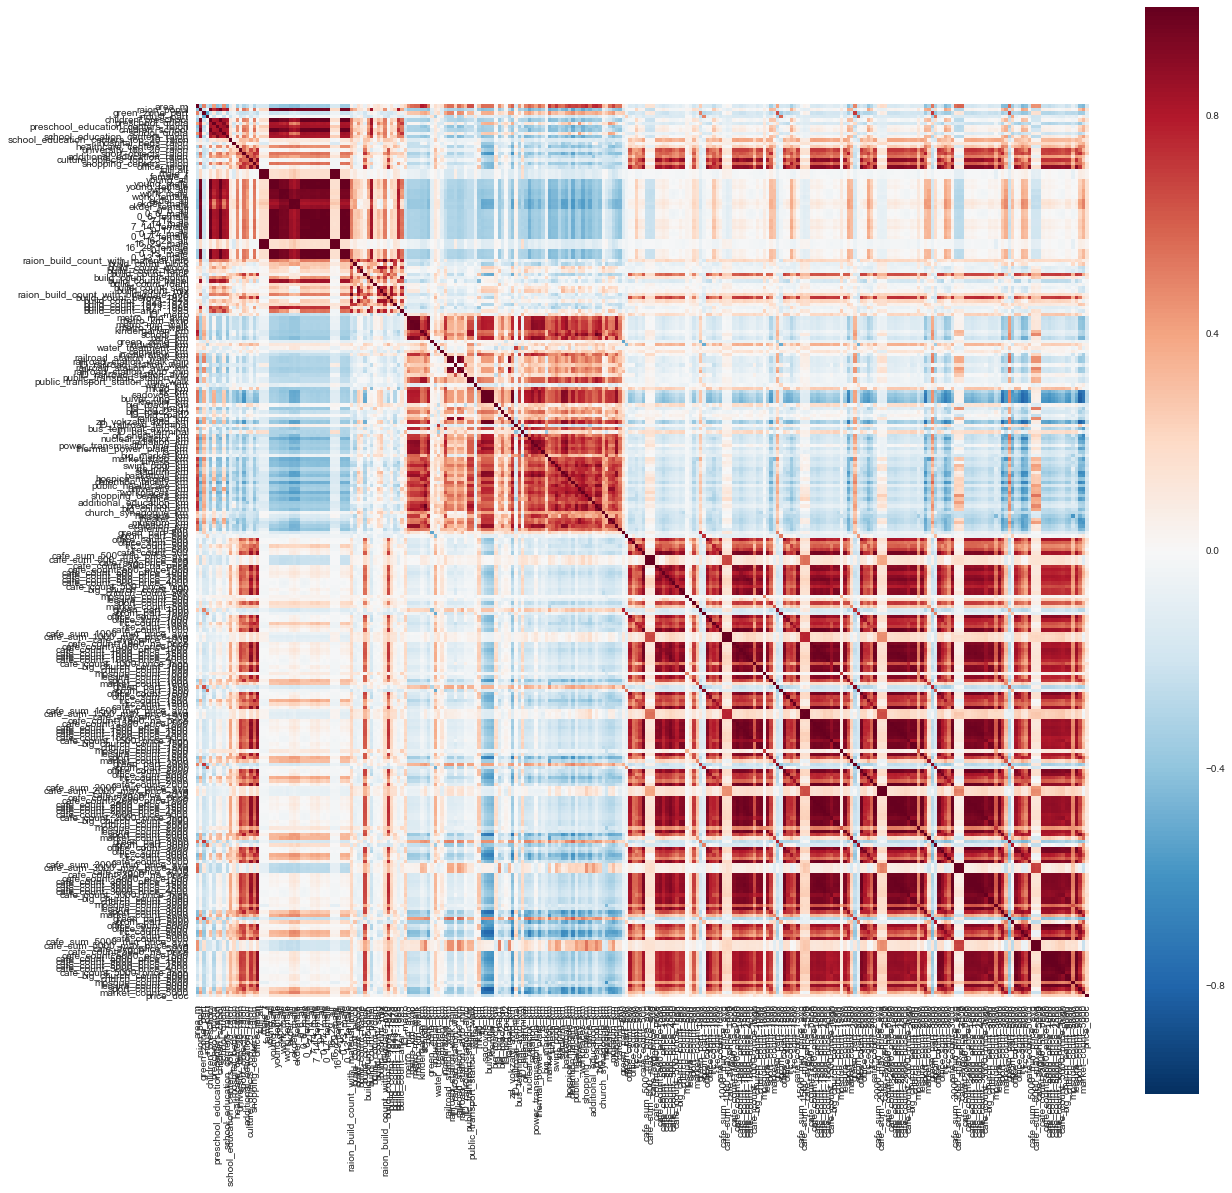

In [13]:
print_correlation_matrix(train_df)

In [14]:
print_top_correlation_indices(train_df)

metro_min_walk                        metro_km_walk                            1.000000
public_transport_station_km           public_transport_station_min_walk        1.000000
children_preschool                    0_6_all                                  1.000000
children_school                       7_14_all                                 1.000000
railroad_station_walk_km              railroad_station_walk_min                1.000000
raion_build_count_with_material_info  raion_build_count_with_builddate_info    0.999990
young_all                             0_13_all                                 0.999885
young_female                          0_13_female                              0.999871
young_male                            0_13_male                                0.999861
full_all                              female_f                                 0.999850
                                      male_f                                   0.999788
young_all                       

## Distances

"metro_min_walk" and "metro_km_walk" are equivalent. Like "public_transport_station_km" and "public_transport_station_min_walk". And variables related with car "avto"

In [21]:
columns_to_delete = ['metro_min_walk', 'public_transport_station_min_walk','railroad_station_walk_min',
                    'metro_min_avto','metro_km_avto','railroad_station_avto_km', 'railroad_station_avto_min']

## people

- all = male + female
- exists: 0_6, 0_13, 0_17, 7_14, 16_29, full, young, work, ekder

In [22]:
#Fetch 'all' related
all_col = get_columns_satisfying_regex('.*all$')

columns_to_delete += all_col

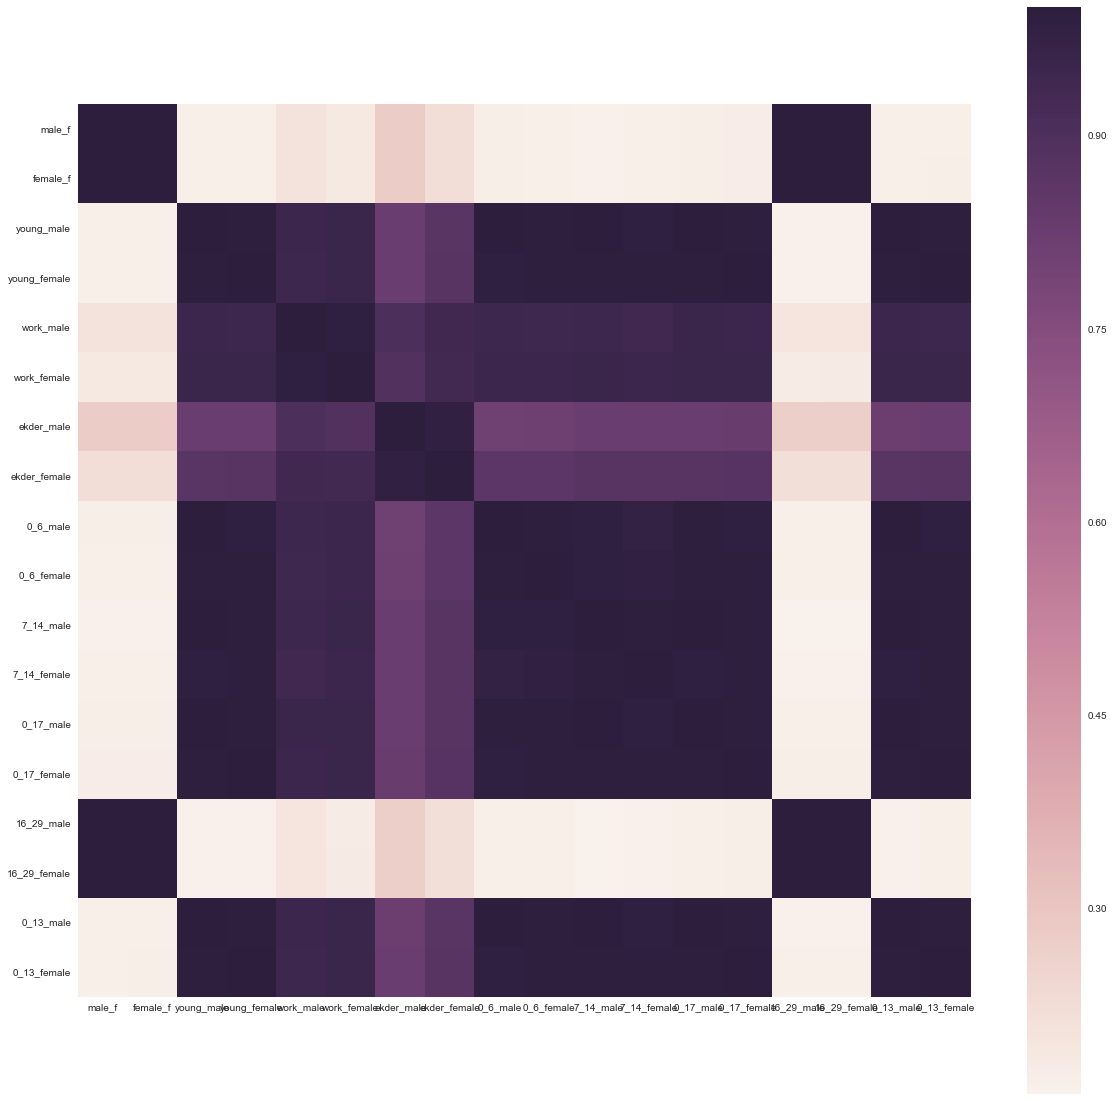

In [18]:
#Fetch fe(male) related
male_col = get_columns_satisfying_regex('.*male.*')

people_subset = train_df[male_col]
print_correlation_matrix(people_subset)

"all_col" will be removed, "0_13", "0_17", "young" and also "children_school" and "children_preschool" because they are the same as "7_14_all" and "0_6_all".

In [23]:
columns_to_delete += ["0_13_male","0_13_female","0_17_male","0_17_female", "young_male","young_female",
                      "children_school", "children_preschool"]

In [24]:
print_top_correlation_indices(train_df.drop(columns_to_delete, 1))

raion_build_count_with_material_info  raion_build_count_with_builddate_info    0.999990
school_km                             preschool_km                             0.999431
cafe_sum_5000_max_price_avg           cafe_avg_price_5000                      0.999367
male_f                                female_f                                 0.999282
                                      16_29_male                               0.999215
female_f                              16_29_female                             0.999163
cafe_sum_3000_max_price_avg           cafe_avg_price_3000                      0.998925
bulvar_ring_km                        kremlin_km                               0.998804
cafe_sum_5000_min_price_avg           cafe_avg_price_5000                      0.998479
sadovoe_km                            bulvar_ring_km                           0.998443
female_f                              16_29_male                               0.998342
male_f                          

## Proximity

In [25]:
counts_columns = get_columns_satisfying_regex(".*_count_.*")

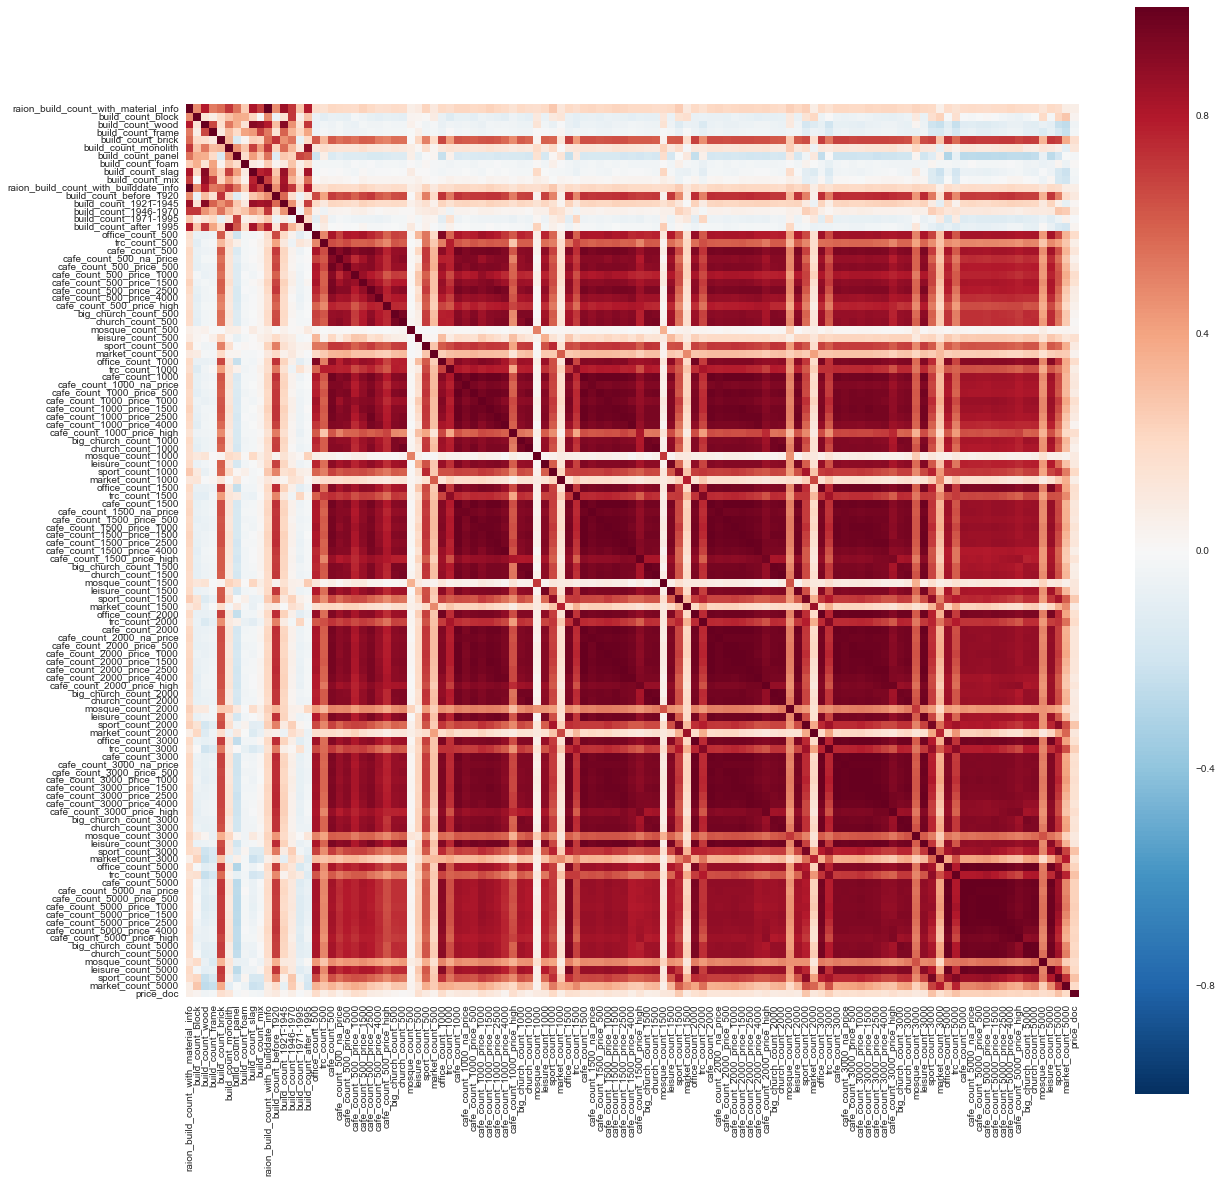

In [26]:
print_correlation_matrix(train_df[counts_columns + ["price_doc"]])

Filter by 500m, 2km and 5km (random numbers).

In [27]:
close_columns = get_columns_satisfying_regex(".*[^(build)]_count_[^((500)|(2000)|(5000))].*")
columns_to_delete += close_columns

## Other proximities

In [28]:
columns_to_delete += get_columns_satisfying_regex(".*_part_[^((500)|(2000)|(5000))].*")

## Cafe
Stuff related with cafes

In [30]:
#Fetch 'cafe' related
cafe_col = get_columns_satisfying_regex('.*cafe.*')

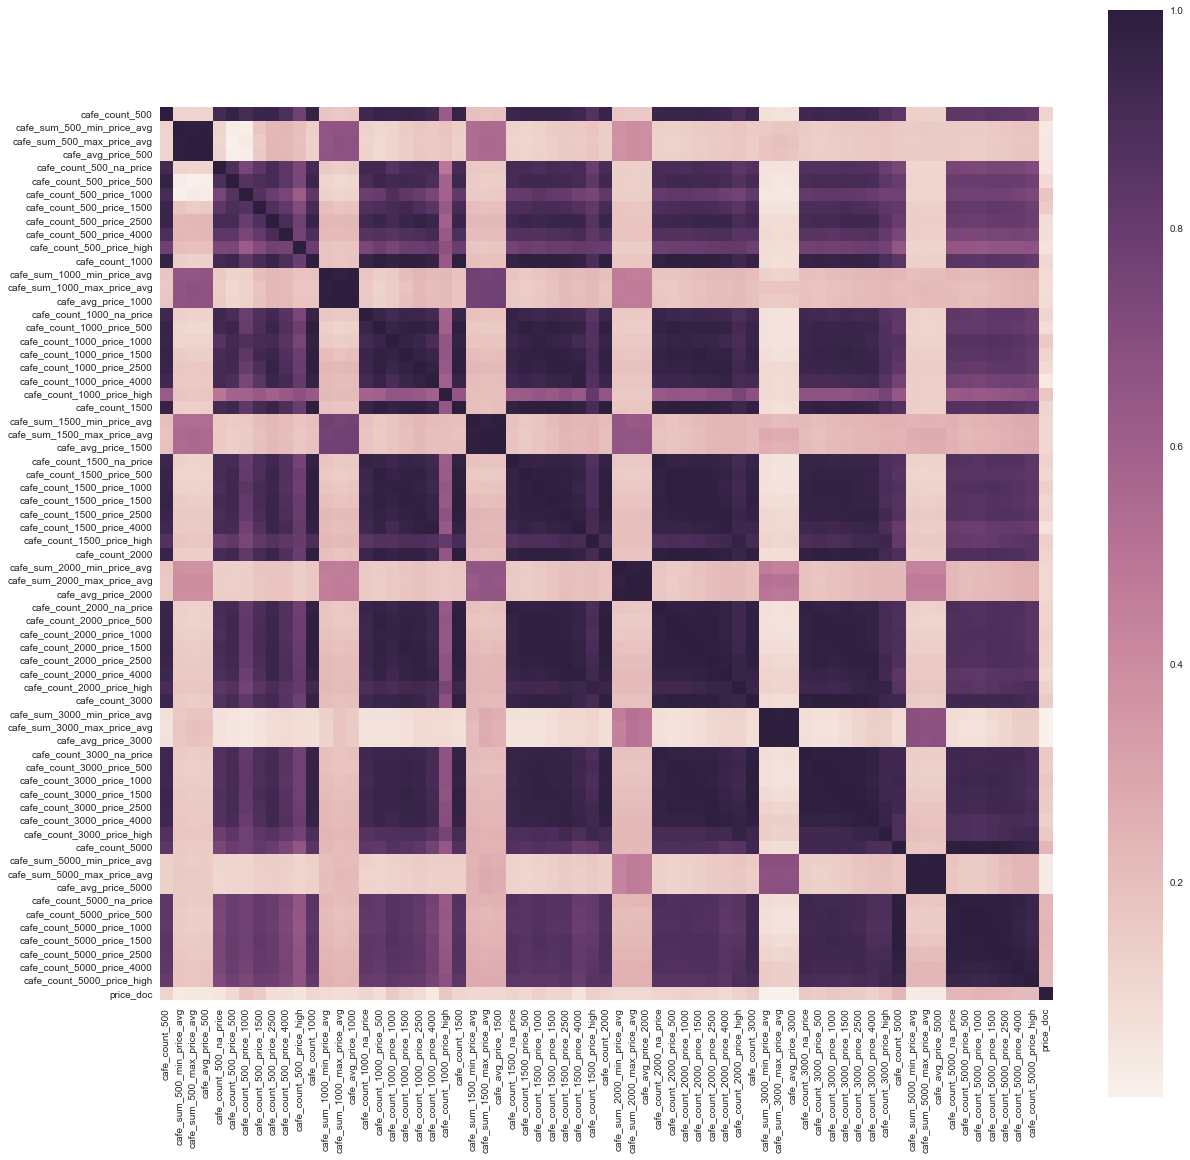

In [31]:
cafe_subset = train_df[cafe_col + ["price_doc"]]
print_correlation_matrix(cafe_subset)

In [32]:
print_top_correlation_indices(cafe_subset)

cafe_sum_5000_max_price_avg  cafe_avg_price_5000            0.999367
cafe_sum_3000_max_price_avg  cafe_avg_price_3000            0.998925
cafe_sum_5000_min_price_avg  cafe_avg_price_5000            0.998479
cafe_count_5000              cafe_count_5000_price_1500     0.998287
cafe_count_3000              cafe_count_3000_price_1500     0.998092
cafe_sum_500_max_price_avg   cafe_avg_price_500             0.998057
cafe_count_5000              cafe_count_5000_price_500      0.997963
cafe_count_3000              cafe_count_3000_price_500      0.997883
cafe_count_2000              cafe_count_2000_price_1500     0.997586
cafe_sum_1000_max_price_avg  cafe_avg_price_1000            0.997345
cafe_sum_3000_min_price_avg  cafe_avg_price_3000            0.997323
cafe_count_3000              cafe_count_3000_price_1000     0.997300
cafe_count_5000              cafe_count_5000_price_1000     0.997249
cafe_sum_2000_max_price_avg  cafe_avg_price_2000            0.997158
cafe_sum_1500_max_price_avg  cafe_

remove "max" and "min" and keep just the average

In [33]:
avg_col = get_columns_satisfying_regex('.*((max)|(min))_price_avg')
columns_to_delete += avg_col

also just keep anything related with the 500, 2000 and 5000m distances (already dealt with before)

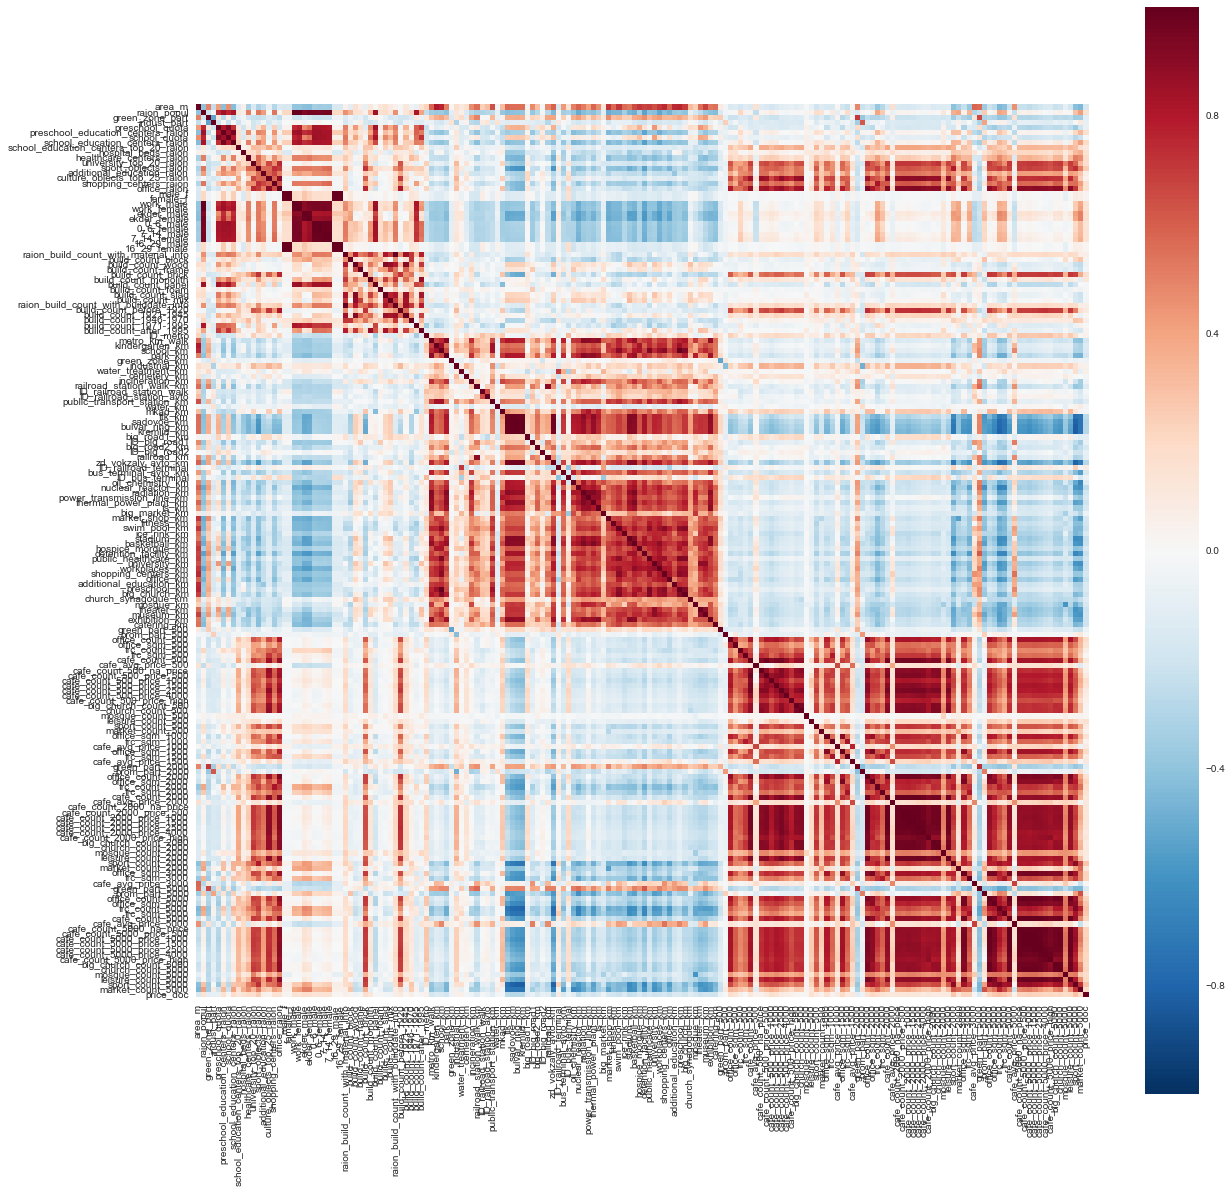

In [34]:
print_correlation_matrix(train_df.drop(columns_to_delete, axis = 1))

In [35]:
print_top_correlation_indices(train_df.drop(columns_to_delete, axis = 1))

raion_build_count_with_material_info  raion_build_count_with_builddate_info    0.999990
school_km                             preschool_km                             0.999431
male_f                                female_f                                 0.999282
                                      16_29_male                               0.999215
female_f                              16_29_female                             0.999163
bulvar_ring_km                        kremlin_km                               0.998804
sadovoe_km                            bulvar_ring_km                           0.998443
female_f                              16_29_male                               0.998342
male_f                                16_29_female                             0.998315
cafe_count_5000                       cafe_count_5000_price_1500               0.998287
16_29_male                            16_29_female                             0.998266
cafe_count_5000                 

## Middle columns

In [36]:
middle_columns = train_df.columns[train_df.columns.get_loc("ID_metro"):train_df.columns.get_loc("ecology")+1]
middle_columns = middle_columns.tolist() + ["price_doc"]

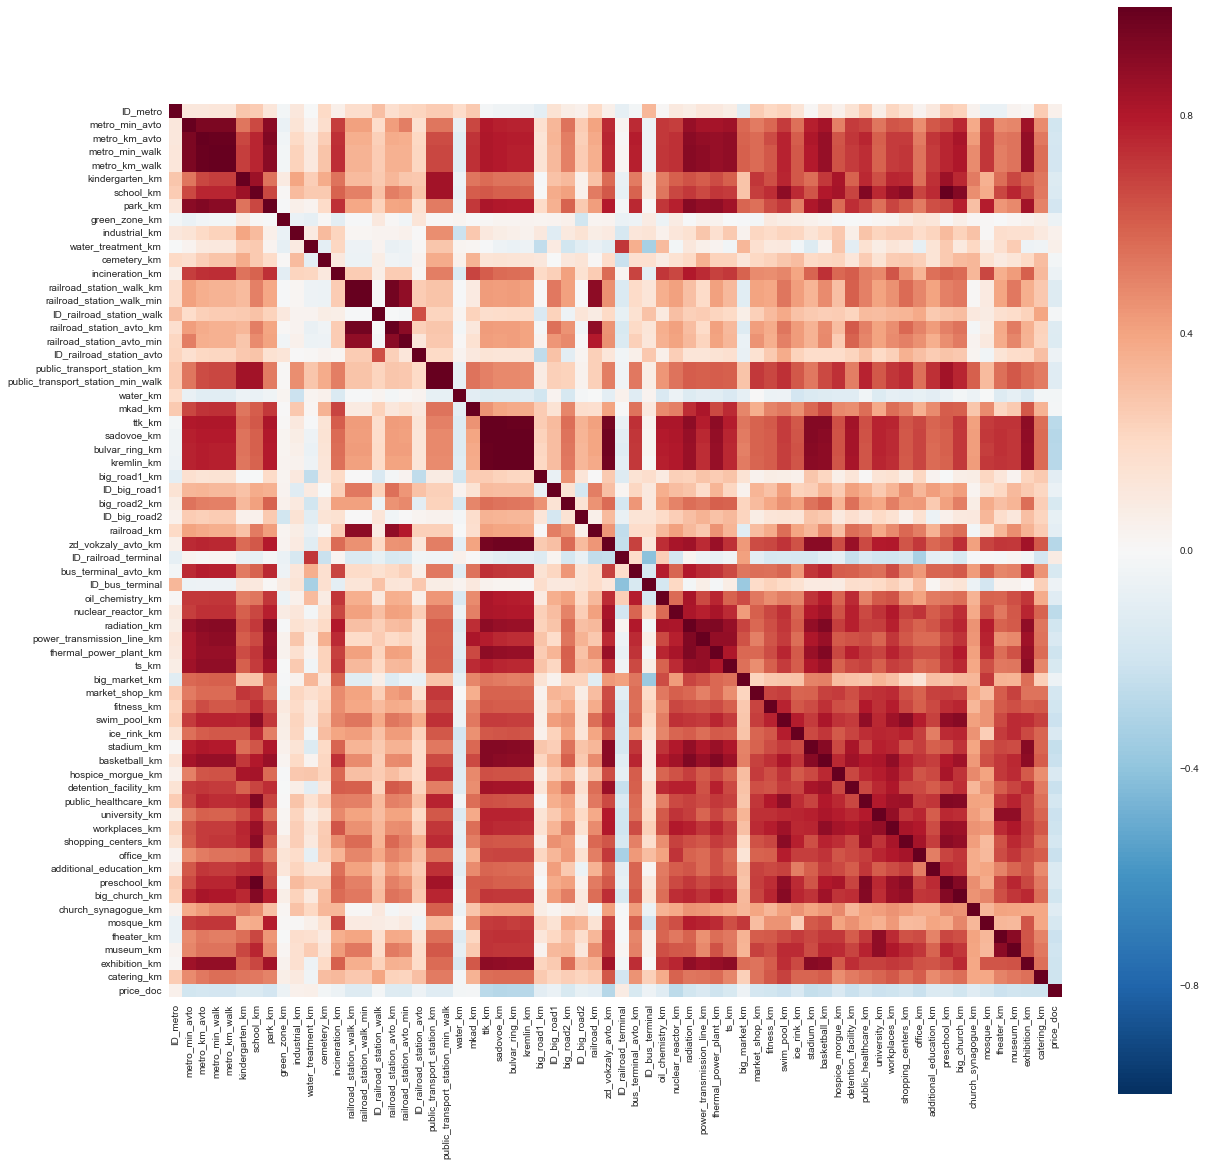

In [37]:
print_correlation_matrix(train_df[middle_columns])

In [38]:
print_top_correlation_indices(train_df[middle_columns])

metro_min_walk                     metro_km_walk                        1.000000
public_transport_station_km        public_transport_station_min_walk    1.000000
railroad_station_walk_km           railroad_station_walk_min            1.000000
school_km                          preschool_km                         0.999431
bulvar_ring_km                     kremlin_km                           0.998804
sadovoe_km                         bulvar_ring_km                       0.998443
                                   kremlin_km                           0.997456
ttk_km                             sadovoe_km                           0.992477
                                   bulvar_ring_km                       0.987004
metro_km_avto                      metro_km_walk                        0.986754
                                   metro_min_walk                       0.986754
ttk_km                             kremlin_km                           0.984562
bulvar_ring_km              

## Subway

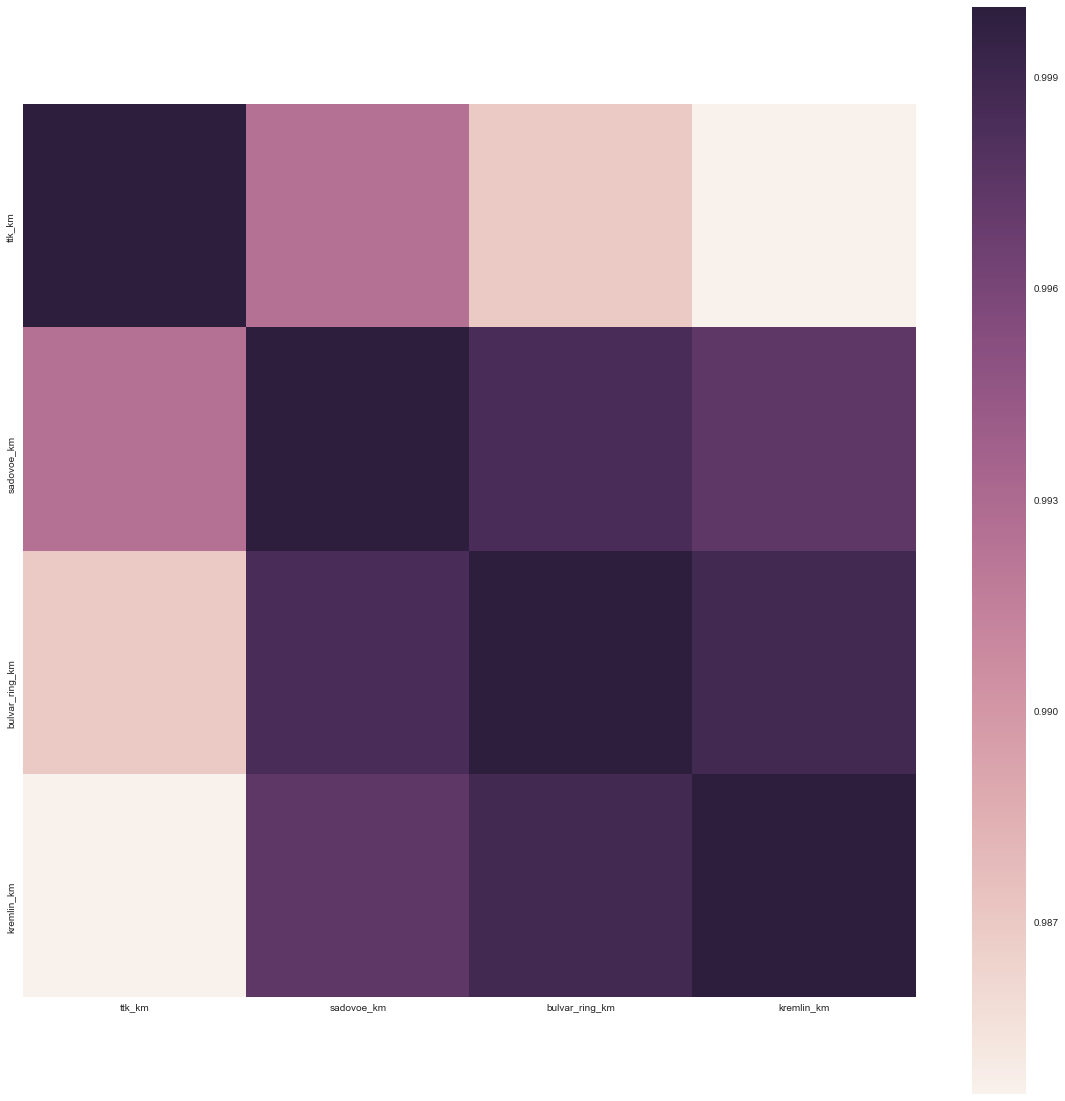

In [39]:
subway_cols = ["ttk_km","sadovoe_km","bulvar_ring_km","kremlin_km"]
print_correlation_matrix(train_df[subway_cols])

In [40]:
columns_to_delete += ["ttk_km","bulvar_ring_km","kremlin_km"]

In [41]:
columns_to_delete += ['raion_build_count_with_material_info','raion_build_count_with_builddate_info'] #useless with other information

In [42]:
columns_to_delete

['metro_min_walk',
 'public_transport_station_min_walk',
 'railroad_station_walk_min',
 'metro_min_avto',
 'metro_km_avto',
 'railroad_station_avto_km',
 'railroad_station_avto_min',
 'full_all',
 'young_all',
 'work_all',
 'ekder_all',
 '0_6_all',
 '7_14_all',
 '0_17_all',
 '16_29_all',
 '0_13_all',
 '0_13_male',
 '0_13_female',
 '0_17_male',
 '0_17_female',
 'young_male',
 'young_female',
 'children_school',
 'children_preschool',
 'office_count_1000',
 'trc_count_1000',
 'cafe_count_1000',
 'cafe_count_1000_na_price',
 'cafe_count_1000_price_500',
 'cafe_count_1000_price_1000',
 'cafe_count_1000_price_1500',
 'cafe_count_1000_price_2500',
 'cafe_count_1000_price_4000',
 'cafe_count_1000_price_high',
 'big_church_count_1000',
 'church_count_1000',
 'mosque_count_1000',
 'leisure_count_1000',
 'sport_count_1000',
 'market_count_1000',
 'office_count_1500',
 'trc_count_1500',
 'cafe_count_1500',
 'cafe_count_1500_na_price',
 'cafe_count_1500_price_500',
 'cafe_count_1500_price_1000',
 

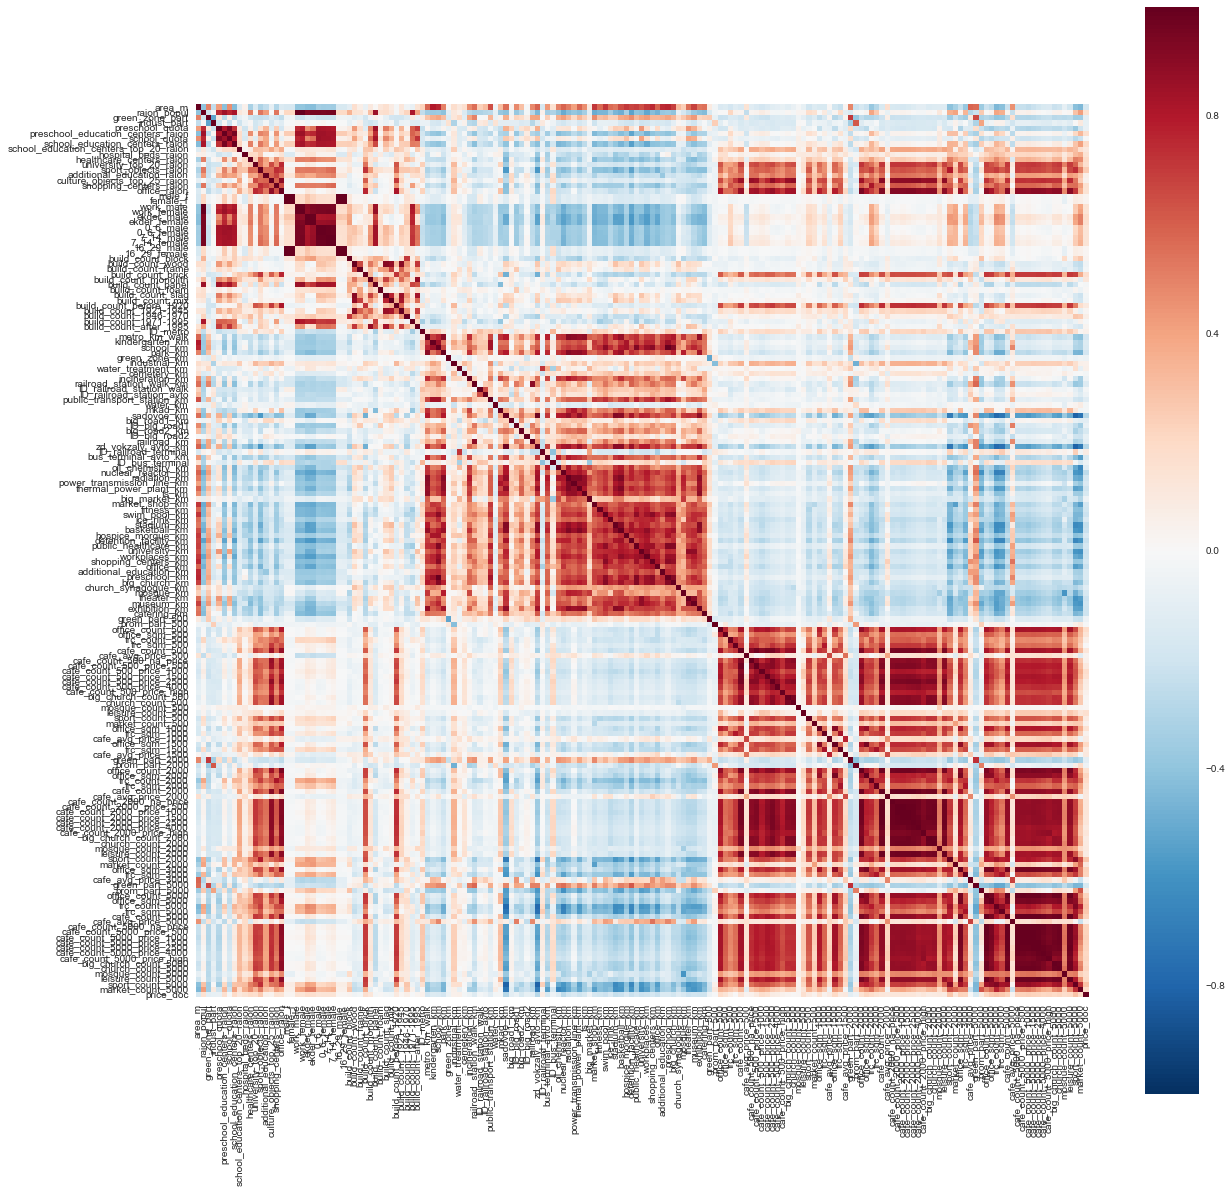

In [43]:
print_correlation_matrix(train_df.drop(columns_to_delete, axis = 1))

## Other string variables
The following string variables (obtained before) will be converted to categories as well.
['culture_objects_top_25',
 'thermal_power_plant_raion',
 'incineration_raion',
 'oil_chemistry_raion',
 'radiation_raion',
 'railroad_terminal_raion',
 'big_market_raion',
 'nuclear_reactor_raion',
 'detention_facility_raion',
 'water_1line',
 'big_road1_1line',
 'railroad_1line',
 'ecology']

### Build counts

Check what the following variables bring to the table:

'build_count_block', 'build_count_wood', 'build_count_frame', 'build_count_brick',
     'build_count_monolith', 'build_count_panel', 'build_count_foam', 'build_count_slag', 'build_count_mix',
     'build_count_before_1920', 'build_count_1921-1945', 'build_count_1946-1970', 'build_count_1971-1995',
     'build_count_after_1995'

In [46]:
columns_to_delete

['metro_min_walk',
 'public_transport_station_min_walk',
 'railroad_station_walk_min',
 'metro_min_avto',
 'metro_km_avto',
 'railroad_station_avto_km',
 'railroad_station_avto_min',
 'full_all',
 'young_all',
 'work_all',
 'ekder_all',
 '0_6_all',
 '7_14_all',
 '0_17_all',
 '16_29_all',
 '0_13_all',
 '0_13_male',
 '0_13_female',
 '0_17_male',
 '0_17_female',
 'young_male',
 'young_female',
 'children_school',
 'children_preschool',
 'office_count_1000',
 'trc_count_1000',
 'cafe_count_1000',
 'cafe_count_1000_na_price',
 'cafe_count_1000_price_500',
 'cafe_count_1000_price_1000',
 'cafe_count_1000_price_1500',
 'cafe_count_1000_price_2500',
 'cafe_count_1000_price_4000',
 'cafe_count_1000_price_high',
 'big_church_count_1000',
 'church_count_1000',
 'mosque_count_1000',
 'leisure_count_1000',
 'sport_count_1000',
 'market_count_1000',
 'office_count_1500',
 'trc_count_1500',
 'cafe_count_1500',
 'cafe_count_1500_na_price',
 'cafe_count_1500_price_500',
 'cafe_count_1500_price_1000',
 

# Imputing missing values

In [58]:
train_df = train_df.drop(columns_to_delete, 1)

In [59]:
num_rows = train_df.shape[0]
non_na_count = train_df.count() 
with_na = non_na_count[non_na_count != num_rows]
with_na

preschool_quota             23783
school_quota                23786
hospital_beds_raion         16030
build_count_block           25480
build_count_wood            25480
build_count_frame           25480
build_count_brick           25480
build_count_monolith        25480
build_count_panel           25480
build_count_foam            25480
build_count_slag            25480
build_count_mix             25480
build_count_before_1920     25480
build_count_1921-1945       25480
build_count_1946-1970       25480
build_count_1971-1995       25480
build_count_after_1995      25480
metro_km_walk               30446
railroad_station_walk_km    30446
ID_railroad_station_walk    30446
cafe_avg_price_500          17190
cafe_avg_price_1000         23947
cafe_avg_price_1500         26272
cafe_avg_price_2000         28746
cafe_avg_price_3000         29480
prom_part_5000              30293
cafe_avg_price_5000         30174
dtype: int64

Check that everything missing from a raion is missing from all the entries for that raion (sub-area)

In [60]:
sub_area_count = train_df.groupby('sub_area').size()

def entire_area_has_this_defined(name):
    na_count = train_df[train_df[name].isnull()].groupby('sub_area').size()
    both = pd.concat([sub_area_count.rename("total_count"),na_count.rename("na_count")], 1, join = 'inner')
    return np.all(both['total_count'] == both['na_count']) #check if all areas that have nan, only have nan

def get_affected_areas(name):
    na_count = train_df[train_df[name].isnull()].groupby('sub_area').size()
    both = pd.concat([sub_area_count.rename("total_count"),na_count.rename("na_count")], 1, join = 'inner')
    return np.any(both['total_count'] == both['na_count']) #from variables that have nan, check if area is completely nan

In [61]:
for var in with_na.index.tolist():
    print('%s gave %s' % (var, entire_area_has_this_defined(var)))

preschool_quota gave True
school_quota gave True
hospital_beds_raion gave True
build_count_block gave True
build_count_wood gave True
build_count_frame gave True
build_count_brick gave True
build_count_monolith gave True
build_count_panel gave True
build_count_foam gave True
build_count_slag gave True
build_count_mix gave True
build_count_before_1920 gave True
build_count_1921-1945 gave True
build_count_1946-1970 gave True
build_count_1971-1995 gave True
build_count_after_1995 gave True
metro_km_walk gave False
railroad_station_walk_km gave False
ID_railroad_station_walk gave False
cafe_avg_price_500 gave False
cafe_avg_price_1000 gave False
cafe_avg_price_1500 gave False
cafe_avg_price_2000 gave False
cafe_avg_price_3000 gave False
prom_part_5000 gave False
cafe_avg_price_5000 gave False


AVG values takes NAN because there aren't cafes, so we assign these values 0. "'cafe\_avg\_price\_(\d+)"

In [62]:
print(get_affected_areas('metro_km_walk'))
print(get_affected_areas('railroad_station_walk_km'))
print(get_affected_areas('ID_railroad_station_walk'))
print(get_affected_areas('prom_part_5000'))

False
False
False
False


Other false (metro_km_walk, railroad_station_walk_km, ID_railroad_station_walk, prom_part_5000) have all subareas partially filled, so fill nan with the average in each sub_area (except ID_railroad_station_walk where we fill the mode)

In [63]:
build_count_regex = re.compile('build_count_(.*)+')
wn = with_na.index.tolist()
build_count_list = [m.group(0) for l in wn for m in [build_count_regex.search(l)] if m]

In [64]:
pd.concat([train_df['sub_area'],train_df[build_count_list].isnull()],1).groupby('sub_area').sum()

,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,...,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995
sub_area,,,,,,,,,,,
Ajeroport,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
Akademicheskoe,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
Alekseevskoe,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
Altuf'evskoe,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
Arbat,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
Babushkinskoe,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
Basmannoe,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
Begovoe,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
Beskudnikovskoe,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0


These subareas have no information about the building, so we impute the average of all records

In [66]:
other_true_cols = ['preschool_quota', 'school_quota', 'hospital_beds_raion']
pd.concat([train_df['sub_area'],train_df[other_true_cols].isnull()],1).groupby('sub_area').sum()

,preschool_quota,school_quota,hospital_beds_raion
sub_area,,,
Ajeroport,0.0,0.0,0.0
Akademicheskoe,0.0,0.0,0.0
Alekseevskoe,0.0,0.0,0.0
Altuf'evskoe,0.0,0.0,68.0
Arbat,0.0,0.0,0.0
Babushkinskoe,0.0,0.0,0.0
Basmannoe,0.0,0.0,0.0
Begovoe,0.0,0.0,0.0
Beskudnikovskoe,0.0,0.0,0.0
